# Traffic Forecasting - Time Series using Neural Network

**About the data**

This dataset is a collection of numbers of vehicles at four junctions at an hourly frequency. 
The CSV file provides four features:

* DateTime
* Junctions
* Vehicles
* ID

The sensors on each of these junctions were collecting data at different times, hence the traffic data from different time periods. Some of the junctions have provided limited or sparse data.

# Importing Libraries

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
from keras.models import load_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
import pickle

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
#Loading Data
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


# Checking Missing values 

In [4]:
data.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

# Data Exploration
* Pharsing dates
* Ploting timeseris
* Feature engineering for EDA

In [5]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

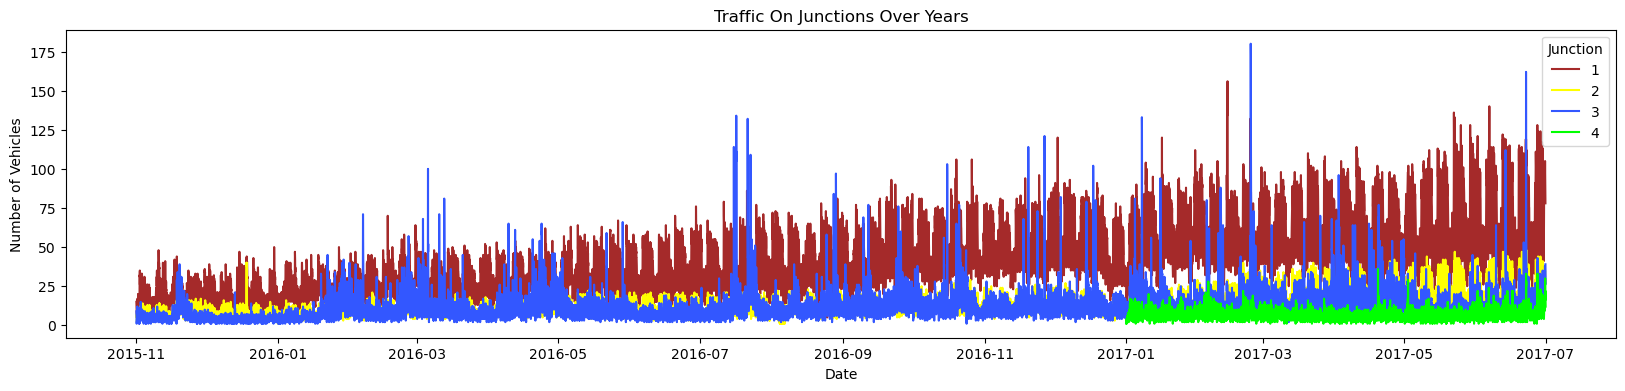

In [6]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
#colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
#colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33E6"]
colors = ["#A52A2A", "#FFFF00", "#3357FF", "#00FF00"]
#colors = 'colorblind'
plt.figure(figsize=(20,4)) #facecolor="white")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

**Noticeable information in the above plot:**

* It can be seen here that the first junction is visibly having an upward trend.
* The data for the fourth junction is sparse starting only after 2017
* Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it. 

# Feature Engineering

In this step, I am creating a few new features out of DateTime. 
Namely:
* Year
* Month 
* Date in the given month
* Days of week 
* Hour

In [7]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


# Exploratory Data Analysis

Plotting the newly created features

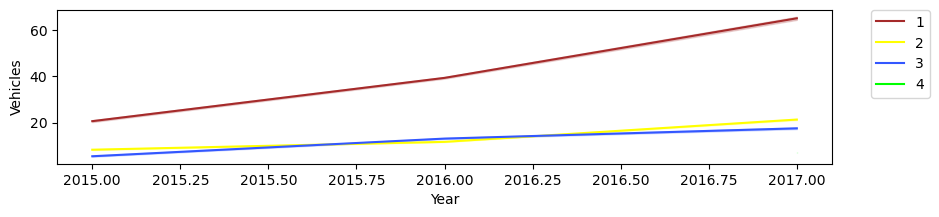

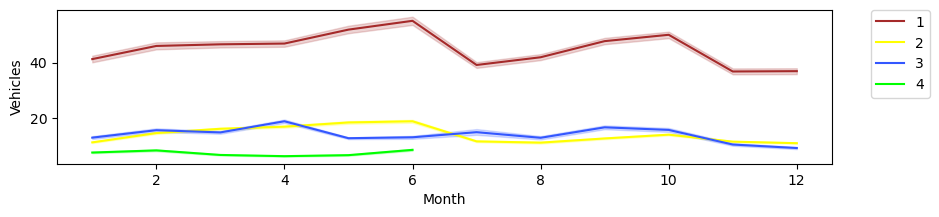

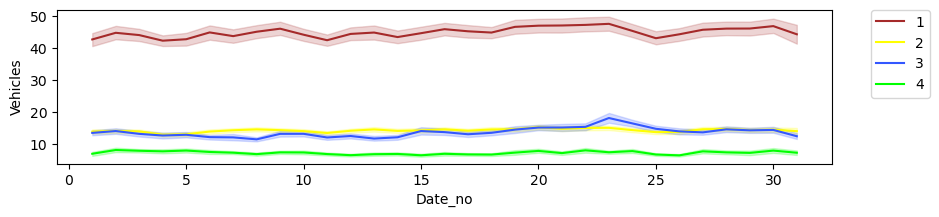

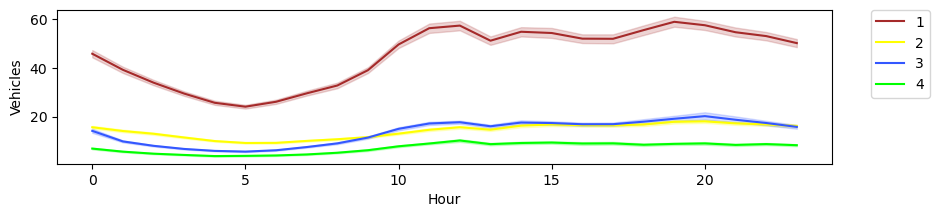

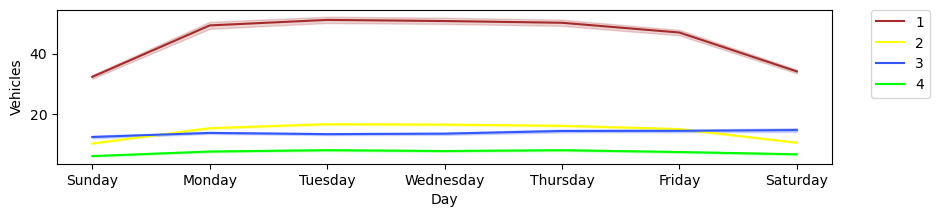

In [8]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]
colors = ["#A52A2A", "#FFFF00", "#3357FF", "#00FF00"]
for i in new_features:
    plt.figure(figsize=(10,2))#,facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**From the above plot following things can be concluded:**


* Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.  

* We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same. 

* Monthly, throughout all the dates there is a good consistency in data. 

* For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation. 

* For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady. 


Text(0.5, 0, 'Date')

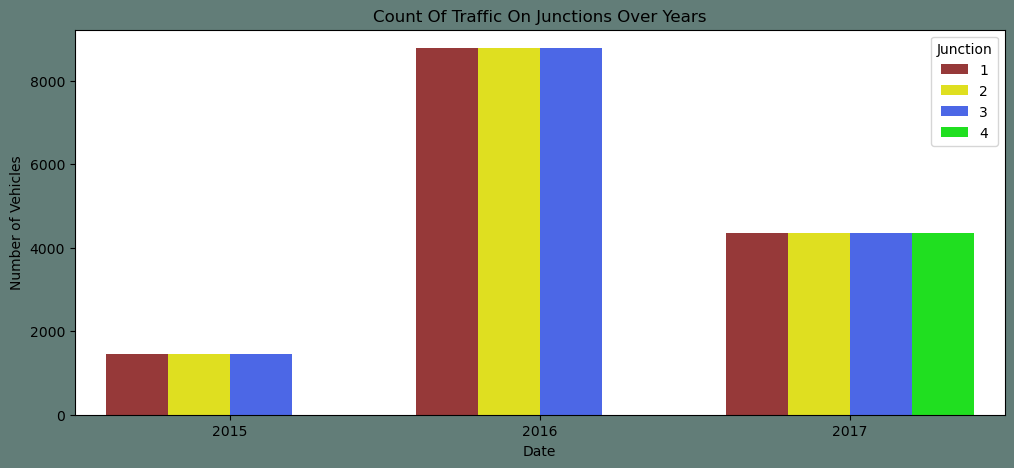

In [9]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month. 

<Axes: >

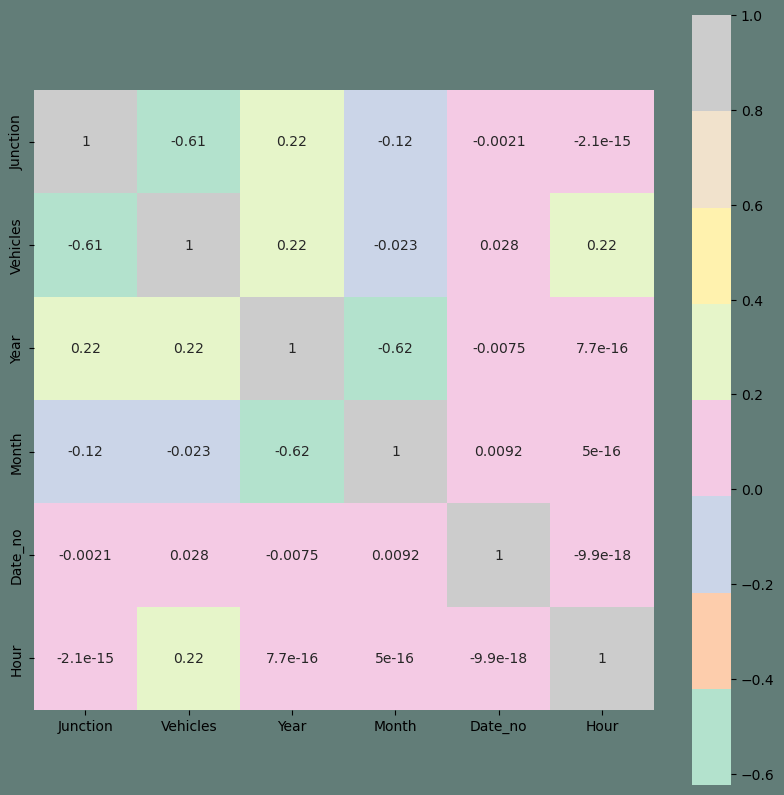

In [10]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

The highest correlation is certainly with the preexisting feature. 

I will conclude my EDA with a pair plot. It's an interesting overall representation of any data. 

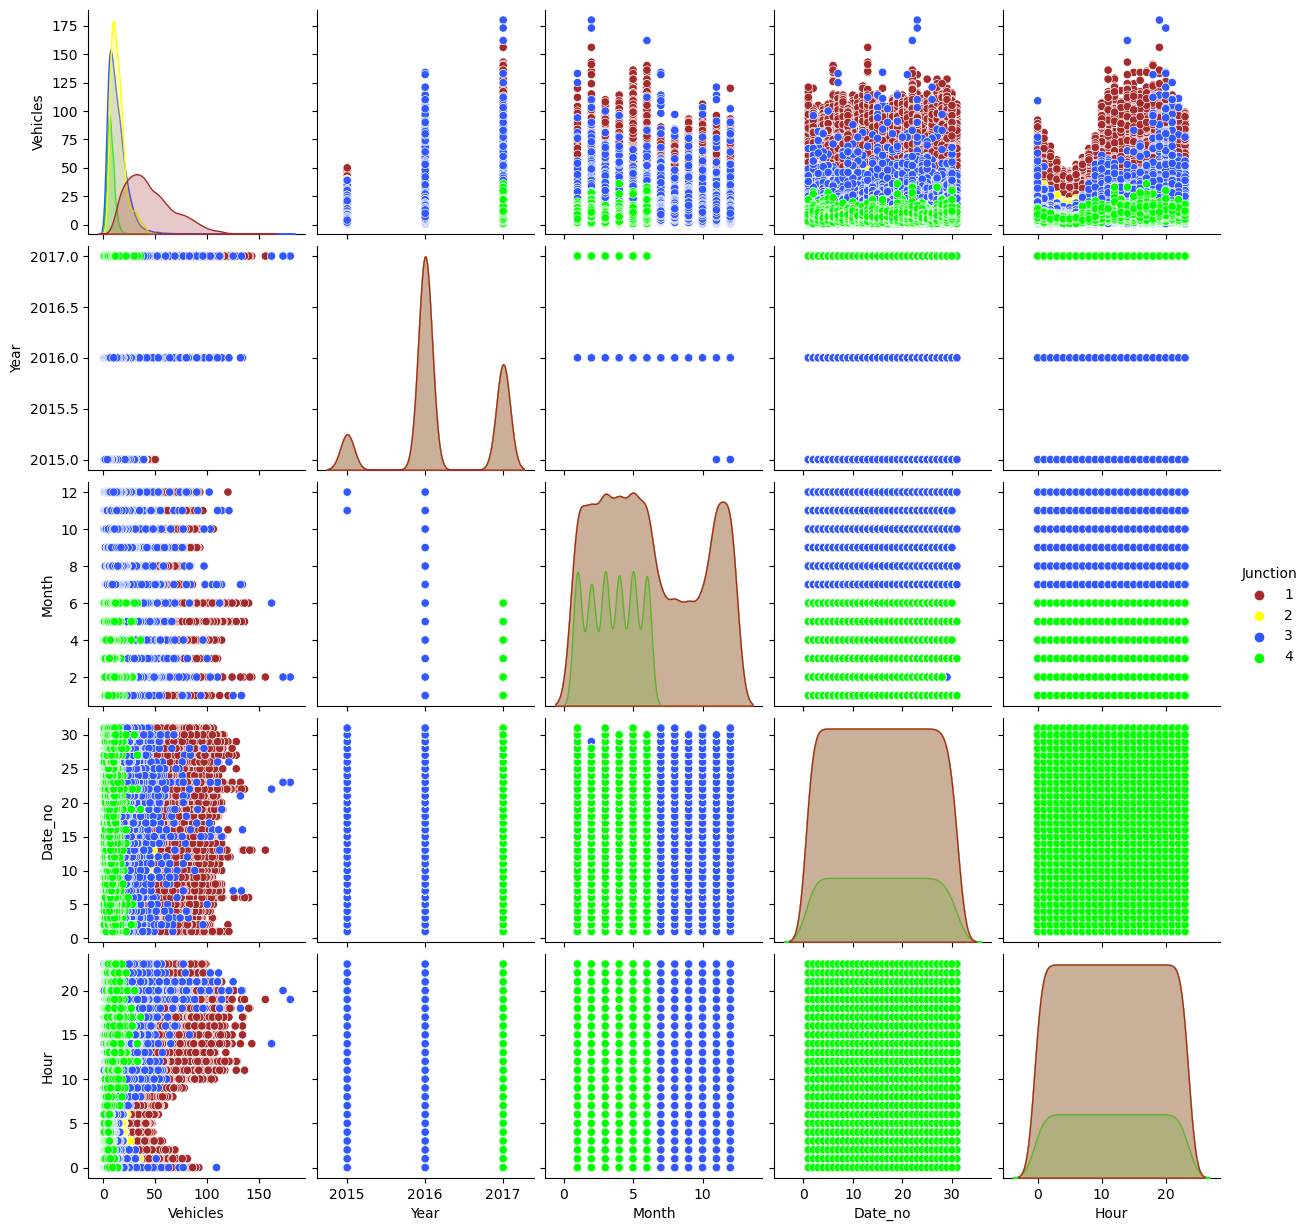

In [11]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

**Conclusions that I have come to draw after this EDA**

* The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
* The yearly trend for Junctions one, two and three have diffrent slopes. 
* Junction number one has a more strong weekly seasonality in comparison to the other junctions. 

For the above-postulated reasons, I think that junctions must be transformed as per their individual needs. 



# Data Transformation And Preprocessing

In [12]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [13]:
df_J

Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]

In [14]:
df_J.columns

MultiIndex([('Vehicles', 1),
            ('Vehicles', 2),
            ('Vehicles', 3),
            ('Vehicles', 4)],
           names=[None, 'Junction'])

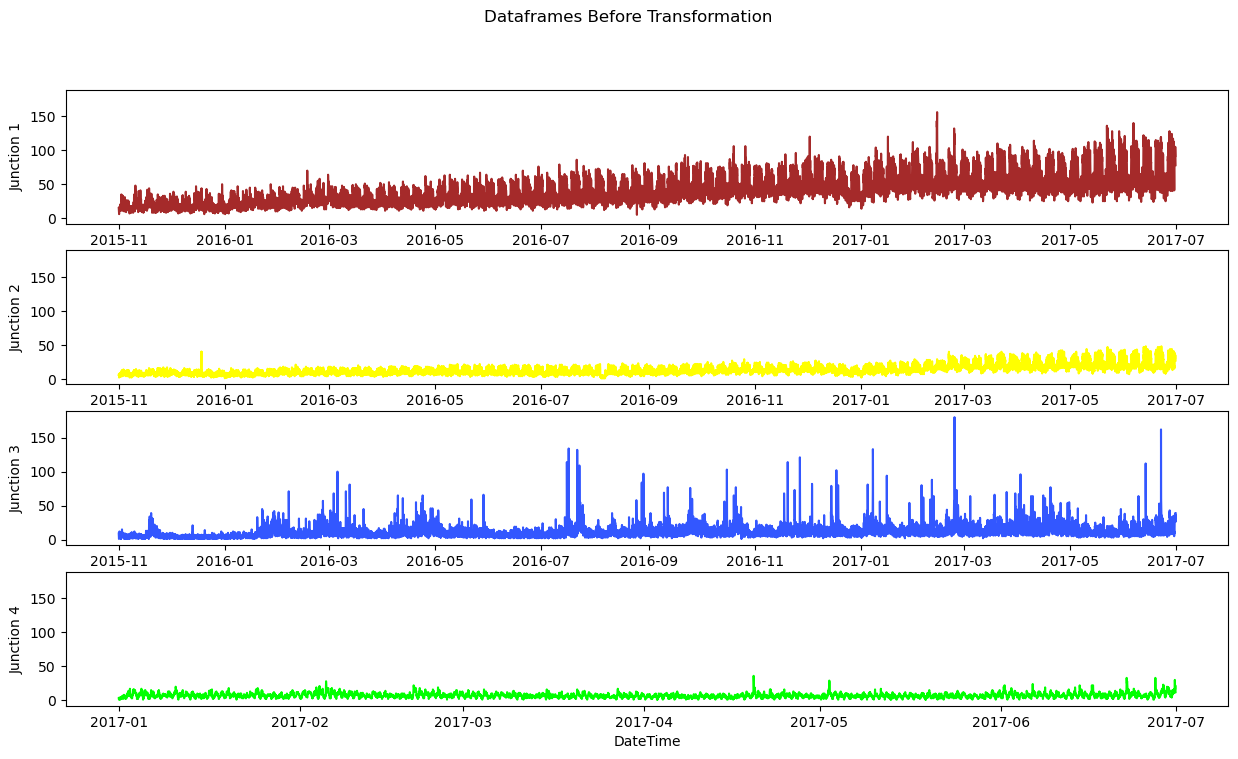

In [15]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)#,facecolor="white", 
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

**Steps for Transforming:**
* Normalizing 
* Differencing 

In [16]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:
* For Junction one, I will be taking a difference of weekly values. 
* For junction two, The difference of consecutive days is a better choice
* For Junctions three and four, the difference of the hourly values will serve the purpose. 

In [17]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

**Plots of Transformed Dataframe**

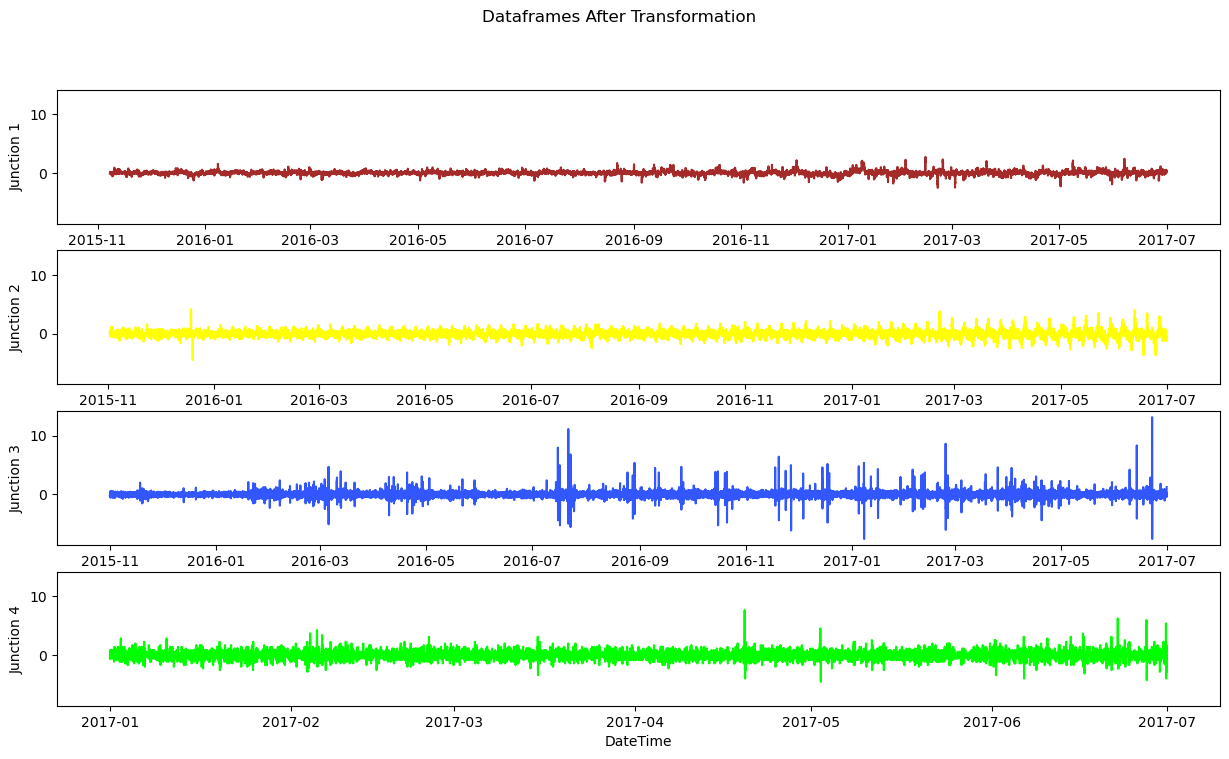

In [18]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

The plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test. 

In [19]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415426
p-value: 4.7985398763968885e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940296
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832412
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305261
p-value: 2.778787532594783e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


**Now that the data is stationary,  preprocessing the data for the neural net by:**

* Splitting the test train sets
* Assigning X as features and y as target 
* Reshaping data for neural net

In [20]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

# Model Building

In [21]:
#Model for the prediction
#from tensorflow.keras.optimizers import SGD
#from tensorflow.keras import callbacks

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9
    
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=0.01),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping, callbacks.LearningRateScheduler(lr_schedule)])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# Fitting The Model

**Fitting the first junction and plotting the predictions and test set**


Epoch 1/50

87/87 [==============================] - 66s 512ms/step - loss: 0.0949 - lr: 0.0100
Epoch 2/50
87/87 [==============================] - 46s 532ms/step - loss: 0.0877 - lr: 0.0100
Epoch 3/50
87/87 [==============================] - 45s 519ms/step - loss: 0.0803 - lr: 0.0100
Epoch 4/50
87/87 [==============================] - 46s 532ms/step - loss: 0.0733 - lr: 0.0100
Epoch 5/50
87/87 [==============================] - 48s 555ms/step - loss: 0.0690 - lr: 0.0100
Epoch 6/50
87/87 [==============================] - 46s 524ms/step - loss: 0.0672 - lr: 0.0100
Epoch 7/50
87/87 [==============================] - 46s 524ms/step - loss: 0.0671 - lr: 0.0100
Epoch 8/50
87/87 [==============================] - 47s 540ms/step - loss: 0.0664 - lr: 0.0100
Epoch 9/50
87/87 [==============================] - 49s 558ms/step - loss: 0.0664 - lr: 0.0100
Epoch 10/50
87/87 [==============================] - 44s 501ms/step - loss: 0.0664 - lr: 0.0100
Epoch 11/50
87/87 [============================

87/87 [==============================] - 46s 529ms/step - loss: 0.0644 - lr: 0.0014
Epoch 30/50
87/87 [==============================] - 45s 520ms/step - loss: 0.0646 - lr: 0.0012
Epoch 31/50
87/87 [==============================] - 45s 517ms/step - loss: 0.0647 - lr: 0.0011
Epoch 32/50
87/87 [==============================] - 45s 517ms/step - loss: 0.0645 - lr: 9.8477e-04
Epoch 33/50
87/87 [==============================] - 45s 515ms/step - loss: 0.0641 - lr: 8.8629e-04
Epoch 34/50
87/87 [==============================] - 45s 516ms/step - loss: 0.0641 - lr: 7.9766e-04
Epoch 35/50
87/87 [==============================] - 45s 513ms/step - loss: 0.0646 - lr: 7.1790e-04
Epoch 36/50
87/87 [==============================] - 45s 517ms/step - loss: 0.0644 - lr: 6.4611e-04
Epoch 37/50
87/87 [==============================] - 45s 517ms/step - loss: 0.0641 - lr: 5.8150e-04
Epoch 38/50
87/87 [==============================] - 44s 508ms/step - loss: 0.0642 - lr: 5.2335e-04
Epoch 39/50
87/87 [=====

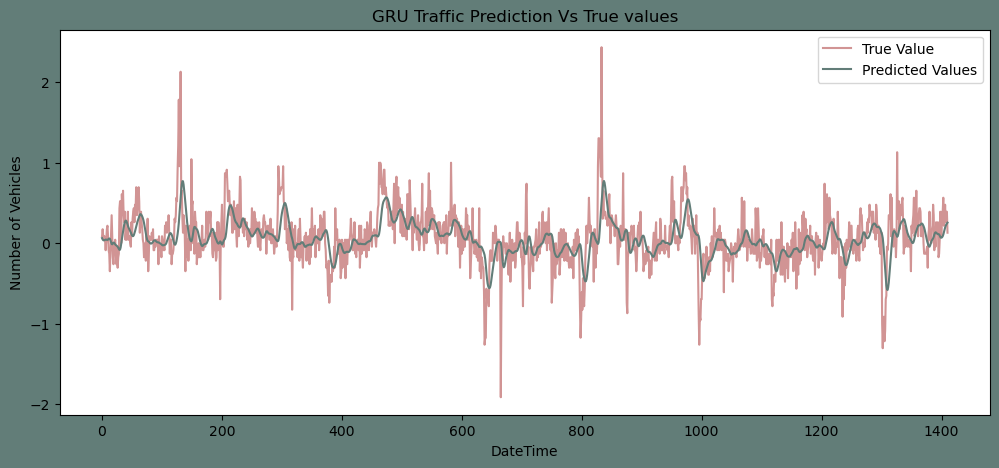

In [22]:
# Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)
RMSE_J1 = RMSE_Value(y_testJ1, PredJ1)
PredictionsPlot(y_testJ1, PredJ1, 0)

# Save the trained model for Junction 2
#with open("junction_1_model.pkl", "wb") as model_file:
    #pickle.dump(model_J1, model_file)

# Save RMSE values
#np.save("junction_1_rmse.npy", RMSE_J1)
# Save the test datasets
#np.save("junction_1_test_features.npy", X_testJ1)

**Fitting the second junction and plotting the predictions and test set**

Epoch 1/50
88/88 [==============================] - 64s 490ms/step - loss: 0.2896 - lr: 0.0100
Epoch 2/50
88/88 [==============================] - 50s 567ms/step - loss: 0.2409 - lr: 0.0100
Epoch 3/50
88/88 [==============================] - 52s 589ms/step - loss: 0.2255 - lr: 0.0100
Epoch 4/50
88/88 [==============================] - 56s 639ms/step - loss: 0.2217 - lr: 0.0100
Epoch 5/50
88/88 [==============================] - 61s 698ms/step - loss: 0.2191 - lr: 0.0100
Epoch 6/50
88/88 [==============================] - 63s 720ms/step - loss: 0.2176 - lr: 0.0100
Epoch 7/50
88/88 [==============================] - 48s 550ms/step - loss: 0.2156 - lr: 0.0100
Epoch 8/50
88/88 [==============================] - 46s 519ms/step - loss: 0.2135 - lr: 0.0100
Epoch 9/50
88/88 [==============================] - 47s 531ms/step - loss: 0.2109 - lr: 0.0100
Epoch 10/50
88/88 [==============================] - 48s 551ms/step - loss: 0.2098 - lr: 0.0100
Epoch 11/50
88/88 [==============================

88/88 [==============================] - 46s 522ms/step - loss: 0.1978 - lr: 0.0012
Epoch 31/50
88/88 [==============================] - 46s 521ms/step - loss: 0.1983 - lr: 0.0011
Epoch 32/50
88/88 [==============================] - 46s 517ms/step - loss: 0.1978 - lr: 9.8477e-04
Epoch 33/50
88/88 [==============================] - 45s 512ms/step - loss: 0.1980 - lr: 8.8629e-04
Epoch 34/50
88/88 [==============================] - 44s 502ms/step - loss: 0.1976 - lr: 7.9766e-04
Epoch 35/50
88/88 [==============================] - 44s 501ms/step - loss: 0.1980 - lr: 7.1790e-04
Epoch 36/50
88/88 [==============================] - 44s 500ms/step - loss: 0.1981 - lr: 6.4611e-04
Epoch 37/50
88/88 [==============================] - 44s 506ms/step - loss: 0.1986 - lr: 5.8150e-04
Epoch 38/50
88/88 [==============================] - 44s 501ms/step - loss: 0.1975 - lr: 5.2335e-04
Epoch 39/50
88/88 [==============================] - 44s 501ms/step - loss: 0.1972 - lr: 4.7101e-04
Epoch 40/50
88/88 [=

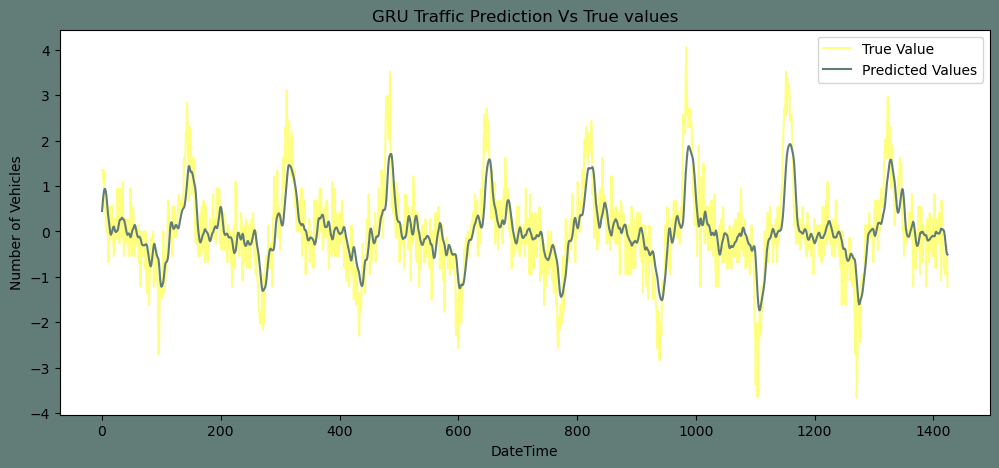

In [23]:
# Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2, y_trainJ2, X_testJ2)
RMSE_J2 = RMSE_Value(y_testJ2, PredJ2)
PredictionsPlot(y_testJ2, PredJ2, 1)

# Save the trained model for Junction 2
#with open("junction_2_model.pkl", "wb") as model_file:
    #pickle.dump(model_J2, model_file)

# Save RMSE values
#np.save("junction_2_rmse.npy", RMSE_J2)
# Save the test datasets
#np.save("junction_2_test_features.npy", X_testJ2)

**Fitting the third junction and plotting the predictions and test set**

Epoch 1/50
88/88 [==============================] - 65s 509ms/step - loss: 0.3044 - lr: 0.0100
Epoch 2/50
88/88 [==============================] - 46s 521ms/step - loss: 0.3035 - lr: 0.0100
Epoch 3/50
88/88 [==============================] - 46s 522ms/step - loss: 0.3027 - lr: 0.0100
Epoch 4/50
88/88 [==============================] - 45s 516ms/step - loss: 0.3021 - lr: 0.0100
Epoch 5/50
88/88 [==============================] - 45s 512ms/step - loss: 0.3013 - lr: 0.0100
Epoch 6/50
88/88 [==============================] - 46s 518ms/step - loss: 0.3007 - lr: 0.0100
Epoch 7/50
88/88 [==============================] - 47s 530ms/step - loss: 0.2997 - lr: 0.0100
Epoch 8/50
88/88 [==============================] - 46s 526ms/step - loss: 0.2988 - lr: 0.0100
Epoch 9/50
88/88 [==============================] - 45s 516ms/step - loss: 0.2977 - lr: 0.0100
Epoch 10/50
88/88 [==============================] - 45s 513ms/step - loss: 0.2968 - lr: 0.0100
Epoch 11/50
88/88 [==============================

88/88 [==============================] - 47s 537ms/step - loss: 0.2885 - lr: 0.0012
Epoch 31/50
88/88 [==============================] - 48s 541ms/step - loss: 0.2881 - lr: 0.0011
Epoch 32/50
88/88 [==============================] - 47s 534ms/step - loss: 0.2883 - lr: 9.8477e-04
Epoch 33/50
88/88 [==============================] - 50s 564ms/step - loss: 0.2881 - lr: 8.8629e-04
Epoch 34/50
88/88 [==============================] - 46s 527ms/step - loss: 0.2880 - lr: 7.9766e-04
Epoch 35/50
88/88 [==============================] - 47s 530ms/step - loss: 0.2880 - lr: 7.1790e-04
Epoch 36/50
88/88 [==============================] - 46s 523ms/step - loss: 0.2887 - lr: 6.4611e-04
Epoch 37/50
88/88 [==============================] - 46s 522ms/step - loss: 0.2884 - lr: 5.8150e-04
Epoch 38/50
88/88 [==============================] - 46s 525ms/step - loss: 0.2886 - lr: 5.2335e-04
Epoch 39/50
88/88 [==============================] - 48s 547ms/step - loss: 0.2881 - lr: 4.7101e-04
Epoch 40/50
88/88 [=

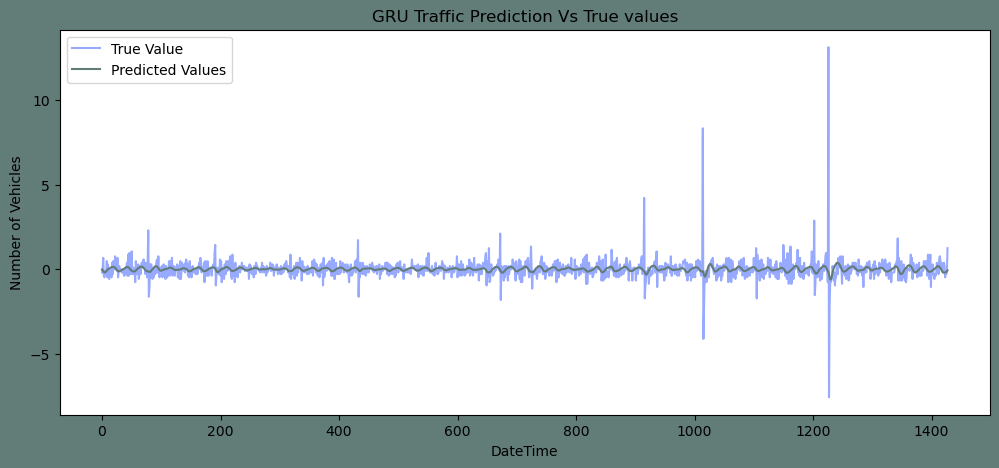

In [24]:
# Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3, y_trainJ3, X_testJ3)
RMSE_J3 = RMSE_Value(y_testJ3, PredJ3)
PredictionsPlot(y_testJ3, PredJ3, 2)

# Save the trained model for Junction 3
#with open("junction_3_model.pkl", "wb") as model_file:
    #pickle.dump(model_J3, model_file)

# Save RMSE values
#np.save("junction_3_rmse.npy", RMSE_J3)
# Save the test datasets
#np.save("junction_3_test_features.npy", X_testJ3)


**Fitting the fourth junction and plotting the predictions and test set**

Epoch 1/50
26/26 [==============================] - 35s 502ms/step - loss: 0.6879 - lr: 0.0100
Epoch 2/50
26/26 [==============================] - 15s 561ms/step - loss: 0.6871 - lr: 0.0100
Epoch 3/50
26/26 [==============================] - 14s 550ms/step - loss: 0.6861 - lr: 0.0100
Epoch 4/50
26/26 [==============================] - 14s 550ms/step - loss: 0.6861 - lr: 0.0100
Epoch 5/50
26/26 [==============================] - 14s 542ms/step - loss: 0.6851 - lr: 0.0100
Epoch 6/50
26/26 [==============================] - 14s 541ms/step - loss: 0.6849 - lr: 0.0100
Epoch 7/50
26/26 [==============================] - 15s 561ms/step - loss: 0.6855 - lr: 0.0100
Epoch 8/50
26/26 [==============================] - 15s 588ms/step - loss: 0.6845 - lr: 0.0100
Epoch 9/50
26/26 [==============================] - 14s 557ms/step - loss: 0.6829 - lr: 0.0100
Epoch 10/50
26/26 [==============================] - 15s 567ms/step - loss: 0.6834 - lr: 0.0100
Epoch 11/50
26/26 [==============================

26/26 [==============================] - 14s 529ms/step - loss: 0.6804 - lr: 0.0012
Epoch 31/50
26/26 [==============================] - 14s 536ms/step - loss: 0.6803 - lr: 0.0011
Epoch 32/50
26/26 [==============================] - 14s 542ms/step - loss: 0.6798 - lr: 9.8477e-04
Epoch 33/50
26/26 [==============================] - 15s 563ms/step - loss: 0.6795 - lr: 8.8629e-04
Epoch 34/50
26/26 [==============================] - 14s 542ms/step - loss: 0.6794 - lr: 7.9766e-04
Epoch 35/50
26/26 [==============================] - 14s 542ms/step - loss: 0.6805 - lr: 7.1790e-04
Epoch 36/50
26/26 [==============================] - 14s 556ms/step - loss: 0.6794 - lr: 6.4611e-04
Epoch 37/50
26/26 [==============================] - 14s 528ms/step - loss: 0.6800 - lr: 5.8150e-04
Epoch 38/50
26/26 [==============================] - 13s 515ms/step - loss: 0.6805 - lr: 5.2335e-04
Epoch 39/50
26/26 [==============================] - 14s 536ms/step - loss: 0.6798 - lr: 4.7101e-04
Epoch 40/50
26/26 [=

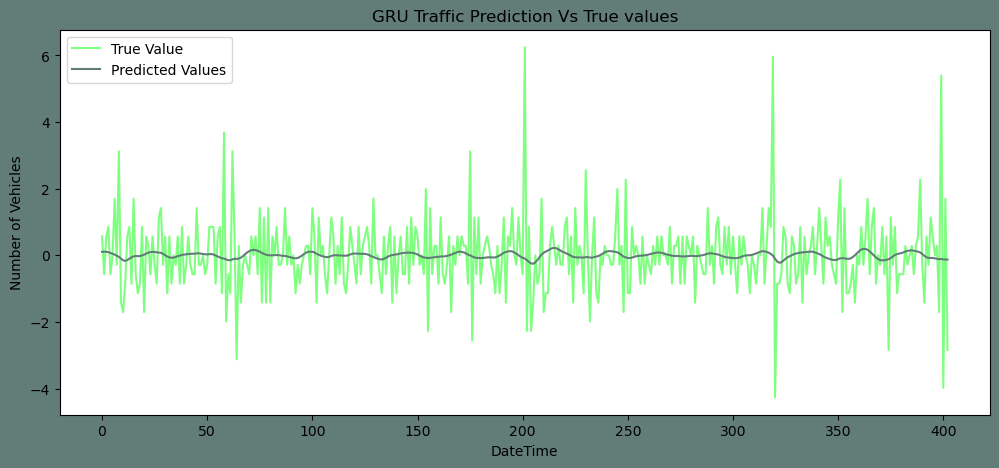

In [25]:
# Predictions For Fourth Junction
PredJ4 = GRU_model(X_trainJ4, y_trainJ4, X_testJ4)
RMSE_J4 = RMSE_Value(y_testJ4, PredJ4)
PredictionsPlot(y_testJ4, PredJ4, 3)

# Save the trained model for Junction 4
#with open("junction_4_model.pkl", "wb") as model_file:
    #pickle.dump(model_J4, model_file)

# Save RMSE values
#np.save("junction_4_rmse.npy", RMSE_J4)
# Save the test datasets
#np.save("junction_4_test_features.npy", X_testJ4)

**The results of the model** 

In [26]:
#Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
list_of_tuples = list(zip(Junctions, RMSE))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")   

,Junction,RMSE
0,Junction1,0.299106
1,Junction2,0.625374
2,Junction3,0.628499
3,Junction4,1.108624


In [29]:
# Calculation of metrics mae, mse and rmse
MAE_J1 = mean_absolute_error(y_testJ1, PredJ1)
MSE_J1 = mean_squared_error(y_testJ1, PredJ1)
#RMSE_J1 = np.sqrt(MSE_J1)

MAE_J2 = mean_absolute_error(y_testJ2, PredJ2)
MSE_J2 = mean_squared_error(y_testJ2, PredJ2)
#RMSE_J2 = np.sqrt(MSE_J2)

MAE_J3 = mean_absolute_error(y_testJ3, PredJ3)
MSE_J3 = mean_squared_error(y_testJ3, PredJ3)
#RMSE_J3 = np.sqrt(MSE_J3)

MAE_J4 = mean_absolute_error(y_testJ4, PredJ4)
MSE_J4 = mean_squared_error(y_testJ4, PredJ4)
#RMSE_J4 = np.sqrt(MSE_J4)

# Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]

# Assuming MSE_J1, MAE_J1, ... are individual values
list_of_tuples = list(zip(Junctions, [MSE_J1, MAE_J1], [MSE_J2, MAE_J2], [MSE_J3, MAE_J3], [MSE_J4, MAE_J4]))

# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "MSE/MAE_J1", "MSE/MAE_J2", "MSE/MAE_J3", "MSE/MAE_J4"])
Results.style.background_gradient(cmap="Pastel1") 

,Junction,MSE/MAE_J1,MSE/MAE_J2,MSE/MAE_J3,MSE/MAE_J4
0,Junction1,0.089465,0.391092,0.395011,1.229048
1,Junction2,0.208297,0.473776,0.316880,0.791817


# Inversing The Transformation Of Data

In [30]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True)#,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Original")

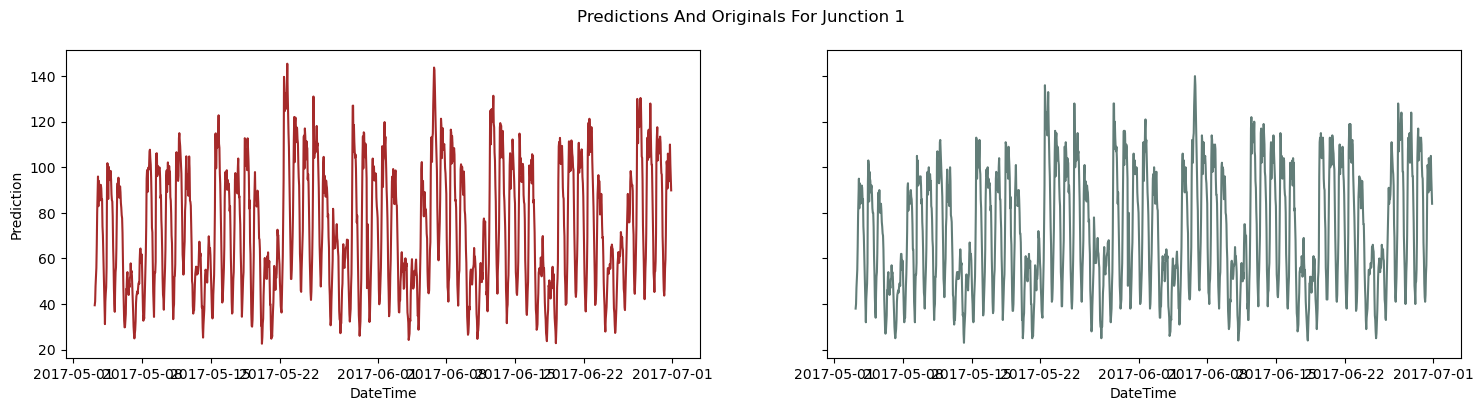

In [31]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Predictions And Originals For Junction 1", 0)

In [32]:
# Saving the average and std for inverse transformation
# Saving for Junction 1
#np.save("junction_1_average.npy", av_J1)
#np.save("junction_1_std.npy", std_J1)

In [33]:
# Save the DataFrame to a CSV file (replace 'your_file_path.csv' with the desired path)
#Transform_reverssed_J1.to_csv('C:/Users/SONY/Downloads/Python/Transform_reverssed_J1.csv', index=False)

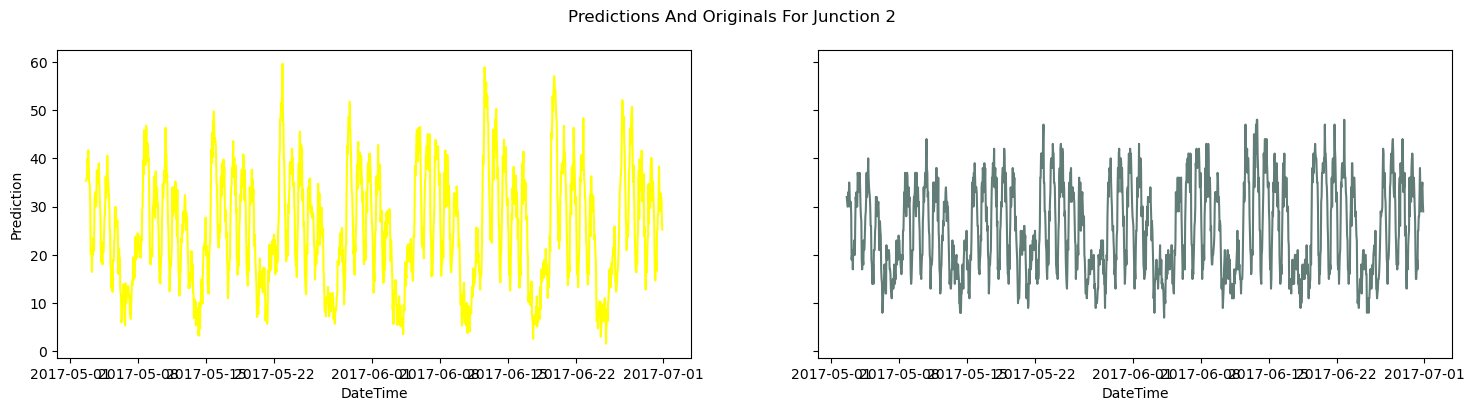

In [34]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Predictions And Originals For Junction 2", 1)

In [35]:
# Saving for Junction 2
#np.save("junction_2_average.npy", av_J2)
#np.save("junction_2_std.npy", std_J2)

In [36]:
# Save the DataFrame to a CSV file (replace 'your_file_path.csv' with the desired path)
#Transform_reverssed_J2.to_csv('C:/Users/SONY/Downloads/Python/Transform_reverssed_J2.csv', index=False)

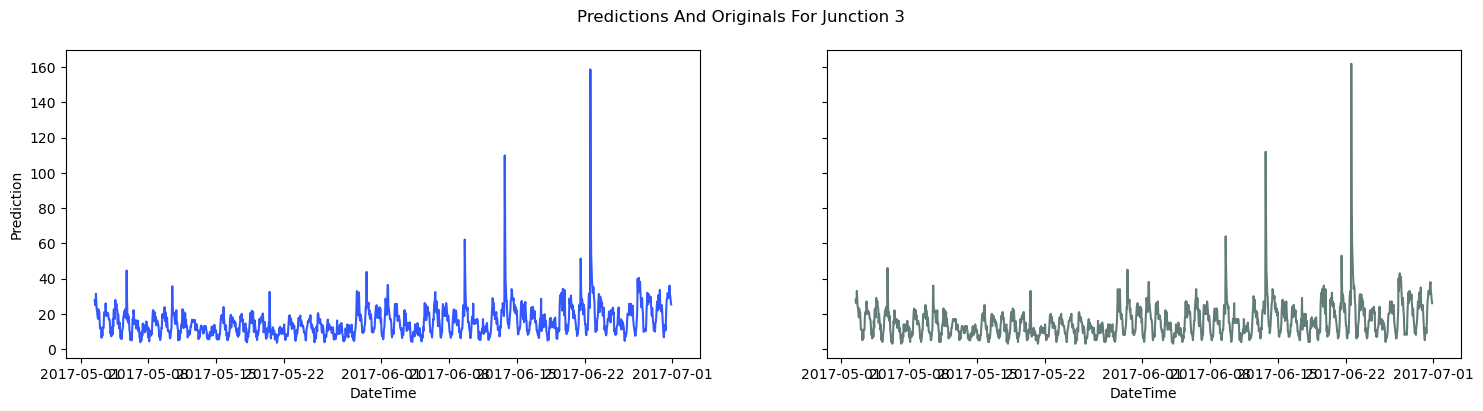

In [37]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Predictions And Originals For Junction 3", 2)

In [38]:
# Saving for Junction 3
#np.save("junction_3_average.npy", av_J3)
#np.save("junction_3_std.npy", std_J3)

In [39]:
# Save the DataFrame to a CSV file (replace 'your_file_path.csv' with the desired path)
#Transform_reverssed_J3.to_csv('C:/Users/SONY/Downloads/Python/Transform_reverssed_J3.csv', index=False)

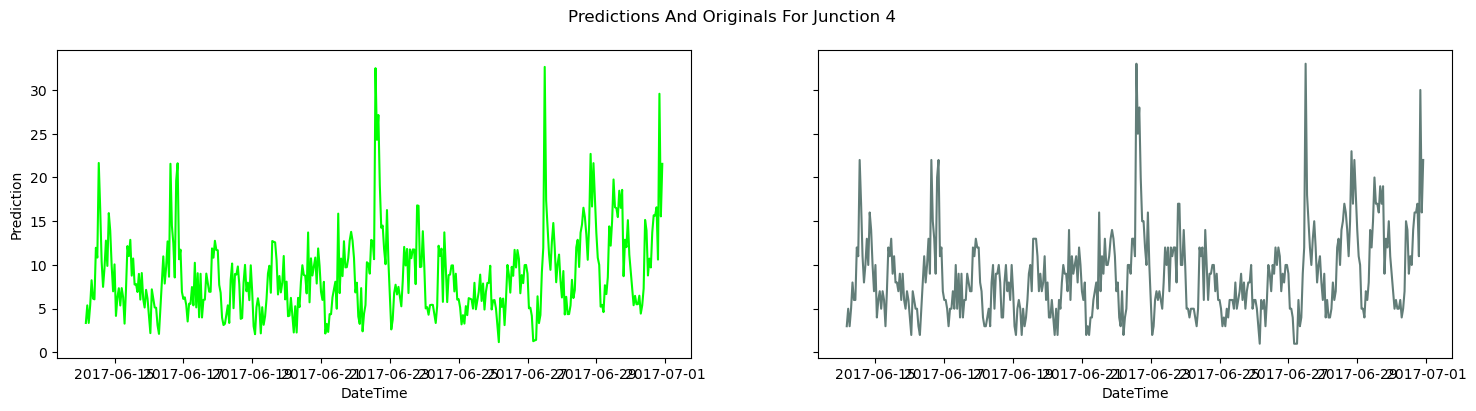

In [40]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Predictions And Originals For Junction 4", 3)

In [41]:
# Saving for Junction 4
#np.save("junction_4_average.npy", av_J4)
#np.save("junction_4_std.npy", std_J4)

In [42]:
# Save the DataFrame to a CSV file (replace 'your_file_path.csv' with the desired path)
#Transform_reverssed_J4.to_csv('C:/Users/SONY/Downloads/Python/Transform_reverssed_J4.csv', index=False)

In [43]:
# Save the true test datasets for Junctions
#np.save("junction_1_test_y.npy", y_testJ1)
#np.save("junction_2_test_y.npy", y_testJ2)
#np.save("junction_3_test_y.npy", y_testJ3)
#np.save("junction_4_test_y.npy", y_testJ4)

**Summary**

*In this project, I trained a GRU Neural network to predicted the traffic on four junctions. 
I used a normalisation and differencing transform to achieve a stationary timeseries. As the Junctions varry in trends and seasonality, I took diffrent approach for each junction to make it stationary. I applyied the root mean squred error as the evaluation metric for the model. In addition to that I plotted the Predictions alongside the original test values.
Take aways from the data analysis:*

*The Number of vehicles in Junction one is rising more rapidly compaired to junction two and three. The sparsity of data in juction four bars me from making any conclusion on the same.*

*The Junction one's traffic has a stronger weekly seasonality as well as hourly seasonality. Where as other junctions are significantly linear.*
